## Length of the report {-}
The length of the report must be no more than 15 pages, when printed as PDF. However, there is no requirement on the minimum number of pages.

You may put additional stuff as Appendix. You may refer to the Appendix in the main report to support your arguments. However, your appendix is unlikely to be checked while grading, unless the grader deems it necessary. The appendix and references will not be included in the page count, and there is no limit on the length of the appendix.

**Delete this section from the report, when using this template.** 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

# Models
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier

OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

## Code should be put separately in the code template {-}
Your report should be in a research-paper like style. If there is something that can only be explained by showing the code, then you may put it, otherwise do not put the code in the report. We will check your code in the code template. 

However, feel free to write code that prints output and then hide the code using the *yaml* setting as shown in an example below *(in the EDA section)*

**Delete this section from the report, when using this template.** 

## Background / Motivation

What motivated you to work on this problem?

Mention any background about the problem, if it is required to understand your analysis later on.

## Problem statement 

Describe your problem statement. Articulate your objectives using absolutely no jargon. 

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

## Stakeholders
Who cares? If you are successful, what difference will it make to them?

## Data quality check / cleaning / preparation 

Show the distribution of the response here. Report the standard deviation and mean in case of a regression problem, and proportion of 0s and 1s in case of classification.

For all other content, as mentioned below, just provide the highlights *(if any)* and put the details in the appendix.

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Mention any useful insights you obtained from the data quality check that helped you develop the model or helped you realize the necessary data cleaning / preparation. Its ok if there were none.

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? Were there missing values? How did you handle them? Its ok if the data was already clean.

Did you do any data wrangling or data preparation before the data was ready to use for model development? Did you create any new predictors from exisiting predictors? For example, if you have number of transactions and spend in a credit card dataset, you may create spend per transaction for predicting if a customer pays their credit card bill. Mention the steps at a broad level, you may put minor details in the appendix. Only mention the steps that ended up being useful towards developing your model(s).

## Exploratory data analysis

If there is any EDA that helped with model development, put it here. If EDA didn't help then mention that, and you may show your EDA effort *(if any)* in the appendix.

List the insights (as bullet points), if any, you got from EDA  that ended up being useful towards developing your final model. 

If there are too many plots / tables, you may put them into appendix, and just mention the insights you got from them.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

EDA for this project helped both inform our decisions on how we would use both the response variables and the numerous predictors.

Our EDA first is used to separate continuous and categorical variables, which wasn’t always clear from the description of variables that the original dataset provided (like hidden categorical variables). We plotted every variable as a barplot, and once those graphs were plotted it was more clear which predictors were categorical (less bars as they focus more on categories. 

<AxesSubplot:xlabel=' shares', ylabel='Density'>

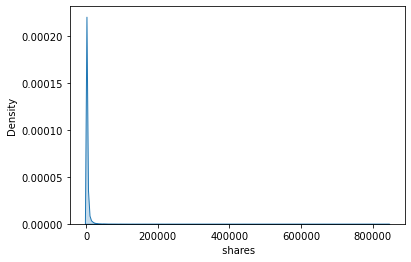

In [26]:
clean = OnlineNewsPopularity.drop(['url'], axis = 1)
response_clean = clean[' shares']
sns.kdeplot(response_clean, fill=True, bw_method = .1)

Second, we plotted the distribution of the response variable in its original state, shares. It showed an extreme left-skewed distribution, with only one or two outliers near the outer ranges of the range. This we hypothesized was due to the response variable not taking into account that one of the predictors, timedelta or time change, increases linearly like shares would over time, logically. Thus, we had looked to log this initially until we altered the response variable completely by dividing shares with timedelta, creating a much more uniform distribution. 

Third, we plotted the distribution of categorical predictors we found using barplots and the continuous predictors with boxplots, which we used to see if there were any extreme outliers. 

Finally, we plotted every predictor against the original response variable, shares, in order to see if, again, there were any abnormalities in the observations. Here, we found that there were 3 particular variables that seemed odd. ‘n_unique_tokens’, ‘n_non_stop_words’,  ‘n_non_stop_unique_tokens’, were all rate-based predictors, with almost all observations falling in between 0 and 1. However, there was a unique observation in all 3, around 700, which doesn;t make sense for a rate-based predictor. 

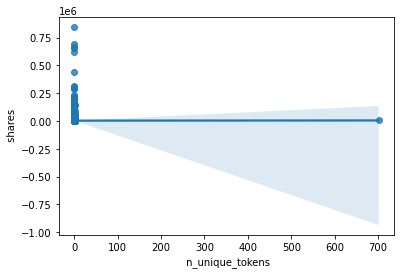

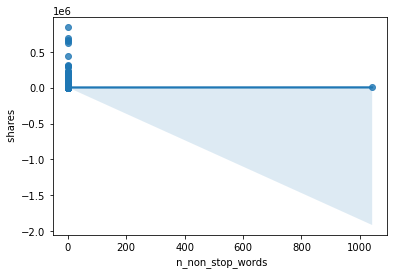

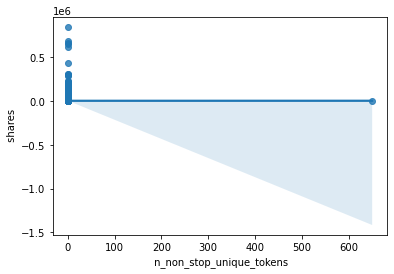

In [8]:
cleaned = OnlineNewsPopularity.drop(['url'], axis = 1)
bad_tokens = cleaned.loc[:, [' n_unique_tokens', ' n_non_stop_words',  ' n_non_stop_unique_tokens', ' shares']]

for x in bad_tokens.columns:
    if x != ' shares':
        sns.regplot(x= x, y = ' shares', data = bad_tokens)
        plt.show()

We realized this may have been a  the observation may have been mis-observed or mislabeled, examining the true value instead of examining it as a rate. Thus, we solved this by simply dividing the observation by the total number of tokens and words later in data cleaning, which made these values rates again, which makes more sense in terms of the data.

In [19]:
data = OnlineNewsPopularity.rename(columns={'url': 'url', ' timedelta': 'timedelta', ' n_tokens_title': "n_tokens_title", ' n_tokens_content': 'n_tokens_content',
       ' n_unique_tokens': 'n_unique_tokens', ' n_non_stop_words': 'n_non_stop_words', ' n_non_stop_unique_tokens': 'n_non_stop_unique_tokens',
       ' num_hrefs': 'num_hrefs', ' num_self_hrefs': 'num_self_hrefs', ' num_imgs': 'num_imgs', ' num_videos': 'num_videos',
       ' average_token_length': 'average_token_length', ' num_keywords': 'num_keywords', ' data_channel_is_lifestyle': 'data_channel_is_lifestyle',
       ' data_channel_is_entertainment': 'data_channel_is_entertainment', ' data_channel_is_bus': 'data_channel_is_bus',
       ' data_channel_is_socmed': 'data_channel_is_socmed', ' data_channel_is_tech': 'data_channel_is_tech',
       ' data_channel_is_world': 'data_channel_is_world', ' kw_min_min': 'kw_min_min', ' kw_max_min': 'kw_max_min', ' kw_avg_min': 'kw_avg_min',
       ' kw_min_max': 'kw_min_max', ' kw_max_max': 'kw_max_max', ' kw_avg_max': 'kw_avg_max', ' kw_min_avg': 'kw_min_avg',
       ' kw_max_avg': 'kw_max_avg', ' kw_avg_avg': 'kw_avg_avg', ' self_reference_min_shares': 'self_reference_min_shares',
       ' self_reference_max_shares': 'self_reference_max_shares', ' self_reference_avg_sharess': 'self_reference_avg_sharess',
       ' weekday_is_monday': 'weekday_is_monday', ' weekday_is_tuesday': 'weekday_is_tuesday', ' weekday_is_wednesday': 'weekday_is_wednesday',
       ' weekday_is_thursday': 'weekday_is_thursday', ' weekday_is_friday': 'weekday_is_friday', ' weekday_is_saturday': 'weekday_is_saturday',
       ' weekday_is_sunday': 'weekday_is_sunday', ' is_weekend': 'is_weekend', ' LDA_00': 'LDA_00', ' LDA_01': 'LDA_01', ' LDA_02': 'LDA_02',
       ' LDA_03': 'LDA_03', ' LDA_04': 'LDA_04', ' global_subjectivity': 'global_subjectivity',
       ' global_sentiment_polarity': 'global_sentiment_polarity', ' global_rate_positive_words': 'global_rate_positive_words',
       ' global_rate_negative_words': 'global_rate_negative_words', ' rate_positive_words' : 'rate_positive_words',
       ' rate_negative_words': 'rate_negative_words', ' avg_positive_polarity': 'avg_positive_polarity',
       ' min_positive_polarity': 'min_positive_polarity', ' max_positive_polarity': 'max_positive_polarity',
       ' avg_negative_polarity': 'avg_negative_polarity', ' min_negative_polarity': 'min_negative_polarity',
       ' max_negative_polarity': 'max_negative_polarity', ' title_subjectivity': 'title_subjectivity',
       ' title_sentiment_polarity': 'title_sentiment_polarity', ' abs_title_subjectivity': 'abs_title_subjectivity',
       ' abs_title_sentiment_polarity': 'abs_title_sentiment_polarity', ' shares': 'shares'})
data.iloc[data.n_unique_tokens.argmax()]
data.iloc[31037].n_non_stop_words
data.iloc[31037].n_non_stop_unique_tokens
data.iloc[31037, data.columns.get_loc('n_unique_tokens')] = data.n_unique_tokens[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_words')] = data.n_non_stop_words[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_unique_tokens')] = data.n_non_stop_unique_tokens[31037]/data.n_tokens_content[31037]

In [21]:
data.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

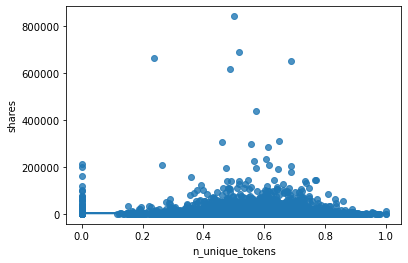

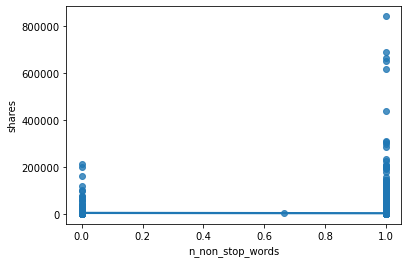

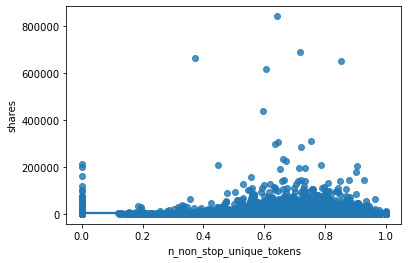

In [25]:
good_tokens = data.loc[:, ['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'shares']]

for x in good_tokens.columns:
    if x != 'shares':
        sns.regplot(x= x, y = 'shares', data = good_tokens)
        plt.show()

## Approach

What kind of a models did you use? What performance metric(s) did you optimize and why?

Is there anything unorthodox / new in your approach? 

What problems did you anticipate? What problems did you encounter? 

Did your problem already have solution(s) (posted on Kaggle or elsewhere). If yes, then how did you build upon those solutions, what did you do differently? Is your model better as compared to those solutions in terms of prediction accuracy or your chosen metric?

**Important: Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.**

## Developing the model: Hyperparameter tuning

Every person must describe their hyperparameter tuning procedure. Show the grid of hyperparameter values over which the initial search was done *(you may paste your grid search / random search / any other search code)*, and the optimal hyperparameter values obtained. After getting the initial search results, how did you make decisions *(if any)* to further fine-tune your model. Did you do another grid / random search or did you tune hyperparameters sequentially? If you think you didn't need any fine tuning after the initial results, then mention that and explain why.

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Lasso, Ridge & Catboost
*By Sylvia Sherwood*

### MARS, AdaBoost & LightGBM
*By Sankaranarayanan Balasubramanian*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put the results of enembling individual models. Feel free to add subsections in this section to add more innovative ensembling methods.

### Voting ensemble

The simplest voting ensemble will be the model where all models have equal weights.

You may come up with innovative methods of estimating weights of the individual models, such as based on their cross-val error. Sometimes, these methods may work better than stacking ensembles, as stacking ensembles tend to overfit.

### Stacking ensemble
Try out different models as the metamodel. You may split work as follows. The person who worked on certain types of models *(say AdaBoost and MARS)* also uses those models as a metamodel in the stacking ensemble.

### Ensemble of ensembled models

If you are creating multiple stacking ensembles *(based on different metamodels)*, you may ensemble them.

### Innovative ensembling methods
*(Optional)*

Some models may do better on certain subsets of the predictor space. You may find that out, and given a data point, choose the model(s) that will best predict for that data point. This is similar to the idea of developing a decision tree metamodel. However, decision tree is prone to overfitting.

Another idea may be to correct the individual models with the intercept and slope *(note the tree-based models don't have an intercept and may suffer from a constant bias)*, and then ensemble them. This is equivalent to having a simple linear regression meta-model for each of the individual models, and then ensembling the meta-models with a meta-metamodel or a voting ensemble.

## Limitations of the model with regard to prediction

Are you confident that you found the optimal hyperparameter values for each of your individual models, and that your individual models cannot be better tuned? Or, are there any models that could be better tuned if you had more time / resources, but you are limited by the amount of time you can spend on the course project *(equivalent to one assignment)*? If yes, then which models could be better tuned and how?

Will it be possible / convenient / expensive for the stakeholders to collect the data relating to the predictors in the model. Using your model, how soon will the stakeholder be able to predict the outcome before the outcome occurs. For example, if the model predicts the number of bikes people will rent in Evanston on a certain day, then how many days before that day will your model be able to make the prediction. This will depend on how soon the data that your model uses becomes available. If you are predicting election results, how many days / weeks / months / years before the election can you predict the results. 

When will your model become too obsolete to be useful?

## Other sections *(optional)*

You are welcome to introduce additional sections or subsections, if required, to address any specific aspects of your project in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions and Recommendations to stakeholder(s)

What conclusions do you draw based on your model? You may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

Add details of each team member's contribution, other than the models contributed, in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 25%;">
       <col span="1" style="width: 40%;">
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Individual Model</th>
    <th>Work other than individual model</th>    
    <th>Details of work other than individual model</th>
  </tr>
  <tr>
    <td>Sylvia Sherwood</td>
    <td>Lasso, Ridge & Catboost</td>
    <td>Data cleaning and EDA</td>    
    <td>Imputed missing values and visualized data</td>
  </tr>
  <tr>
    <td>Sankaranarayanan Balasubramanian</td>
    <td>MARS, AdaBoost & LightGBM</td>
    <td>Ensembling</td>    
    <td>Stacking ensembles and voting ensemble</td>
  </tr>
    <tr>
    <td>Fiona Fe</td>
    <td>Bagged trees & Random forest</td>
    <td>Variable selection</td>    
    <td>Variable selection based on feature importance</td>
  </tr>
    <tr>
    <td>Ryu Kimiko</td>
    <td>XGBoost</td>
    <td>Ensembling</td>    
    <td>Innovative ensemble & stacking ensemble</td> 
  </tr>
</table>

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.